<a href="https://colab.research.google.com/github/Bhavana0929/CNN_from_scratch/blob/main/CNN_from_scratch_putting_everything_together.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting the data and processing it

Creating train and test data

In [ ]:
'''
Input functionality
'''

import pandas as pd
import numpy as np
data = pd.read_csv("https://raw.githubusercontent.com/VikasSingh-DS/Kannada-MNIST/refs/heads/master/train.csv")

data = data.sample(frac=1)
#print(int(data.shape[0]/2))

data_first_half = data.head(30000)
data_second_half = data.tail(30000)

### get 100 data points
### making sure that the data  is balanced
tmp = pd.DataFrame()
for label in range(10):
    if label==0:
        tmp = data_first_half[data_first_half['label']==label].head(600)
    else:
        temp = data_first_half[data_first_half['label']==label].head(600)
        tmp = pd.concat([tmp,temp])
data_balanced = tmp

tmp = pd.DataFrame()
for label in range(10):
    if label==0:
        tmp = data_second_half[data_second_half['label']==label].head(100)
    else:
        temp = data_second_half[data_second_half['label']==label].head(100)
        tmp = pd.concat([tmp,temp])
data_test = tmp

print(data_test.shape)
print(data_balanced.shape)

(1000, 785)
(6000, 785)


De- flattening the data :
* The data frame is de-flattened so that it resembles the shape of an image
* The shape of the data will look like (N,1,28,28).
* N is the number of data points.
* (1,28,28) is the image with one channel.



In [ ]:
### Convert flattened input train data to image data
data_balanced = data_balanced.sample(frac=1)
data_array = np.zeros((data_balanced.shape[0],1,28,28))
image_data = np.array(data_balanced.drop('label',axis=1))

for i in range(data_balanced.shape[0]):
    single_image = image_data[i,:].reshape(1,-1)
    single_image = single_image.reshape(-1,28)
    data_array[i,0,:,:] = single_image
data_array = data_array/255.

### Convert flattened input test data to image data
data_test = data_test.sample(frac=1)
data_test_input = np.zeros((data_test.shape[0],1,28,28))
image_data = np.array(data_test.drop('label',axis=1))

for i in range(data_test.shape[0]):
    single_image = image_data[i,:].reshape(1,-1)
    single_image = single_image.reshape(-1,28)
    data_test_input[i,0,:,:] = single_image
data_test_input = data_test_input/255.

Convert the label data to one hot encoding :

* One hot encoding is a way to encode categorical data.
* Here, we start by converting each label into a vector of zeros. The length of the vector will be equal to the total categories available.
* For each category, we choose a unique position in this vector and flip the 0 at this position to 1.
* For example , if we are trying to classify and image into a cat, dog and flower, we would have the following one hot encoded vectors

   cat -> [0,0,1]

   dog -> [0,1,0]

   flower -> [0,0,1]
* This is important when we are doing multiclass classification problems. The one hot encoded vectors enable us to calculate cross entropy loss, which we have to reduce.

In the below code, we convert the labels in the train data into one hot encodings.



In [ ]:
### Convert Labels to one hot encoding

label = data_balanced['label'].tolist()
one_hot_encoding = np.zeros((data_balanced.shape[0],10))
for i in range(data_balanced.shape[0]):
    position = label[i]
    one_hot_encoding[i,position] = 1

Printing the image data
* The following code will print the image data.

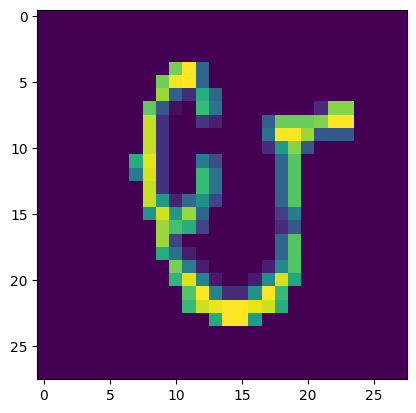

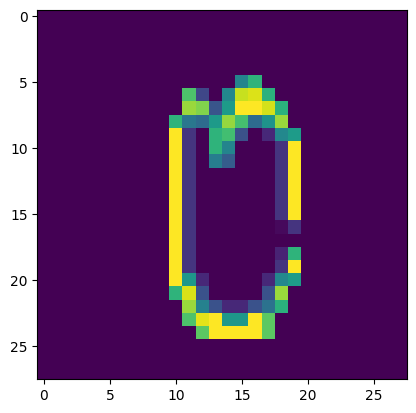

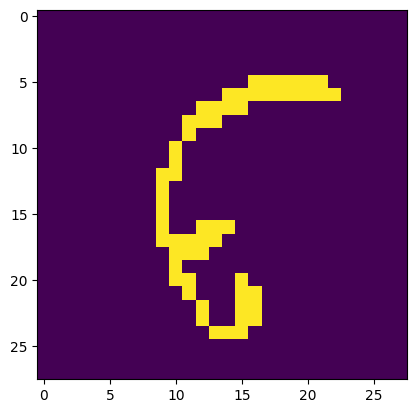

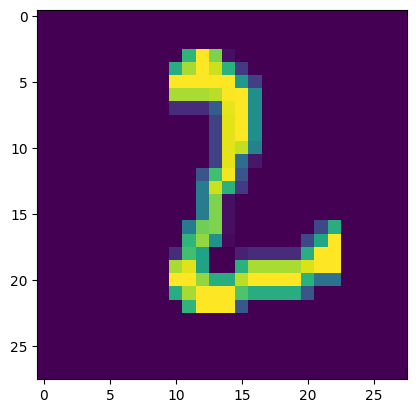

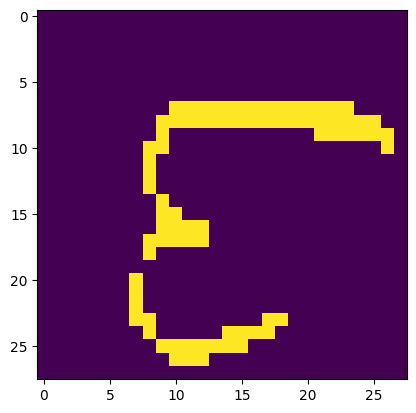

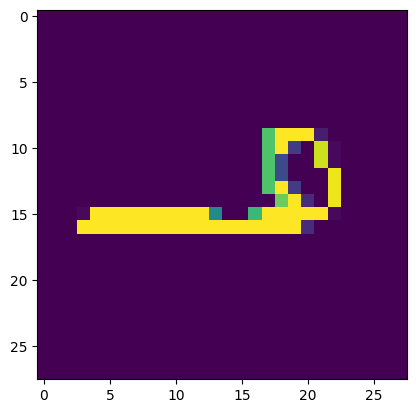

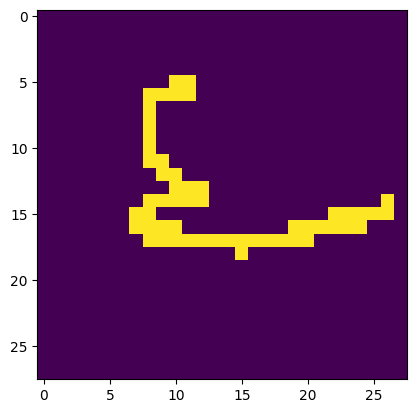

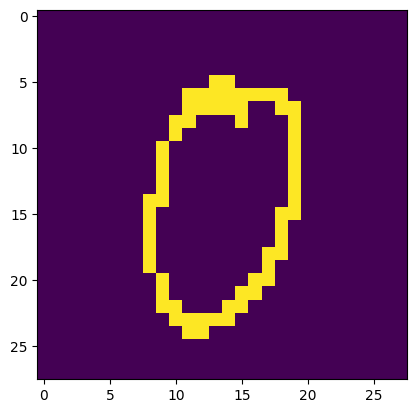

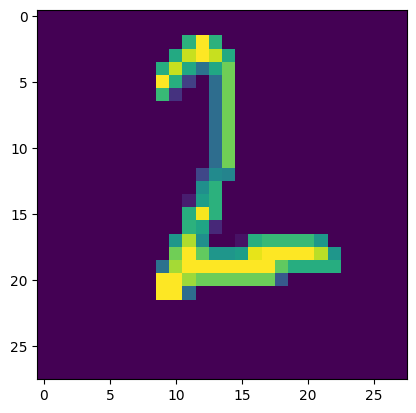

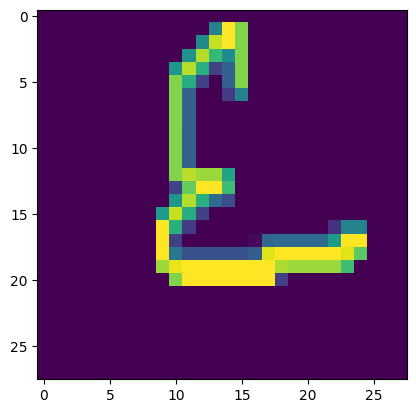

In [ ]:
import matplotlib.pyplot as plt

for i in range(10):
    plt.imshow(data_array[i,0,:,:])
    plt.pause(0.5)

# CNN architecture
The architecture that is used in this classification problem is as follows

* Input Image (shape : 1X1X28X28)
* Convolutional Filter of shape 2X1X5X5
* ReLU function
* 2X2 Maxpooling layer
* 1st Fully Connected Layer with 288 units
* 2nd Fully Connected Layer of 60 units activated with ReLU function
* Output Layer with 10 units normalized by a softmax function

In the following sections, I will briefly try to explain and implement convolution, ReLU ,softmax and maxpool functions

# Convolutional Function

* The convolution operation helps in selectively increasing/decreasing the pixel values of an image to uncover useful patterns/features for classification.
* This is done my using a fixed matrix (convolutional filter matrix) and taking the dot product with chunks of images of the same size. These chunks are chosen recursively based on two parameters ; stride and filter height/width. Stride is how much the convolutional filter moves after each dot product operation.
* Doing convolution the naive way will result in longer processing times as this would involve nested for loops.
* One way to combat this is to use the im2col method. The im2col method converts an image to a 2D array. The column of each array will be the elements that make up each stride of the convolution operation.
* After the image is converted to its im2col form, the convolutional filter is reshaped to a 2D array. Each row of this 2D array will contain a flattened version of each convolutional filter.For example, if we have a convolutional filter of size (2,1,5,5), this means that there are 2 filters of size (1,5,5) each. So after the reshaping, the size of the filter will become (2,25).
* The code snippet below introduces the im2col function.

In [ ]:
def im2col(X,conv1, stride, pad):
    """
        Transforms our input image into a matrix.
        Parameters:
        - X: input image.
        - HF: filter height.
        - WF: filter width.
        - stride: stride value.
        - pad: padding value.
        Returns:
        -cols: output matrix.
    """
    # Padding
    X_padded = np.pad(X, ((0,0), (0,0), (pad, pad), (pad, pad)), mode='constant')
    X = X_padded
    new_height = int((X.shape[2]+(2*pad)-(conv1.shape[2]))/stride)+1
    new_width =  int((X.shape[3]+(2*pad)-(conv1.shape[3]))/stride)+1
    im2col_vector = np.zeros((X.shape[1]*conv1.shape[2]*conv1.shape[3],new_width*new_height*X.shape[0]))
    c = 0
    for position in range(X.shape[0]):
        image_position = X[position,:,:,:]
        for height in range(0,image_position.shape[1],stride):
            image_rectangle = image_position[:,height:height+conv1.shape[2],:]
            if image_rectangle.shape[1]<conv1.shape[2]:
                continue
            else:
                for width in range(0,image_rectangle.shape[2],stride):
                    image_square = image_rectangle[:,:,width:width+conv1.shape[3]]
                    if image_square.shape[2]<conv1.shape[3]:
                        continue
                    else:
                        im2col_vector[:,c:c+1]=image_square.reshape(-1,1)
                        c = c+1
    return(im2col_vector)

* The code snippet below uses im2col to do convolution.

In [ ]:
X_batch = data_array[0:10,:,:,:]
conv1 = np.random.randn(2,1,5,5)

X_im2col = im2col(X=X_batch,conv1=conv1,stride=1,pad=0)
conv1_reshaped = conv1.reshape(conv1.shape[0],-1)
X_conv = conv1_reshaped@X_im2col
X_conv = np.array(np.hsplit(X_conv,X_batch.shape[0])).reshape((X_batch.shape[0],conv1.shape[0],24,24))

# MaxPool
* We use a similar principal for maxpool

In [ ]:
def maxpool_multiple(input_image,stride=2):
    input_width = input_image.shape[3]
    input_height = input_image.shape[2]
    filter_width = 2
    filter_height = 2

    output_width = int((input_width-filter_width)/stride)+1
    output_height = int((input_height-filter_height)/stride)+1

    output_image = np.zeros((input_image.shape[0],input_image.shape[1],output_width,output_height))
    for i in range(output_image.shape[0]):
        output_image[i:i+1,:,:,:] = maxpool(input_image[i:i+1,:,:,:],stride=2)
    return output_image

def maxpool(input_image,stride=2):
    input_width = input_image.shape[3]
    input_height = input_image.shape[2]
    filter_width = 2
    filter_height = 2
    n_channels = input_image.shape[1]
    num_images = input_image.shape[0]

    output_width = int((input_width-filter_width)/stride)+1
    output_height = int((input_height-filter_height)/stride)+1
    output = np.zeros((n_channels,output_width*output_height))
    c=0
    for height in range(0,input_height,stride):
        if height+filter_height<=input_height:
            image_rectangle = input_image[0,:,height:height+filter_height,:]
            for width in range(0,input_width,stride):
                if width+filter_width<=input_width:
                    image_square = image_rectangle[:,:,width:width+filter_width]
                    image_flatten = image_square.reshape(-1,1)
                    #print(image_flatten)
                    #print('----')
                    output[:,c:c+1] = np.array([float(np.max(i)) for i in np.split(image_flatten,n_channels)]).reshape(-1,1)
                    c+=1
    final_output = np.array(np.hsplit(output,1)).reshape((1,n_channels,output_height,output_width))

    return final_output

# ReLU
* The ReLU function filters out all values less than 0.

In [ ]:
def ReLU(x):
    return (x>0)*x

# Softmax
* The softmax() function normalizes the last layer to a probability distribution.
* The predicted target class, will be the one with the highest value after softmax.
* Using softmax helps make the derivative of the last layer with respect to the output, much more easier to calculate.

In [ ]:
def softmax(x):

    x_exp = np.exp(x-np.max(x))

    return x_exp/np.sum(x_exp,axis=0)

# Functions for backpropagation :
* After the signal from the input is passed and processed all the way to the output, it is likely that the estimation of the output is not close to the actual outputs.
* This calls for a mechanism that minimizes this difference; this is called backpropagation.
* The error with respect to the output is calculated at each phase of the CNN from the back to the front. The following code snippets will include functions for ReLU Derivatives, storing indices before maxpooling, and calculating error of convolutional filter with respect to the output.

# Derivative of ReLU :
* The derivative of ReLU makes sure that the values are 1 for all values > 0.
* This function will be used during backpropagation for layers that have the ReLU activation function.

In [ ]:
def dReLU(x):
    return (x>0)*1.0

# Storing indices during maxpooling :
* During forward propagation, the maxpooling filter, chooses the max element in a defined window and passes it on forward to the subsequent layer.
* This process is repeated across the image based on stride and filter size.
* For this example, I have used stride = 2 and filter height/width = 2.
* During backpropagation, the errors in the subsequent layer is then passed back to the positions where the max values were sourced. So , it is important to store the indices of these positions.

In [ ]:
def maxpool_indices(input_image,stride=2,filter_height=2, filter_width=2):
    positional_vector = []

    for channel in range(input_image.shape[1]):
        x = -1

        chosen_image_channel = input_image[:,channel,:,:]
        for height in range(0,chosen_image_channel.shape[1],stride):
            if height+stride<=chosen_image_channel.shape[1]:
                image_rectangle = chosen_image_channel[:,height:height+filter_height,:]
                x = x+1
                y = -1
                #print('Value of x:',x)
                for width in range(0,image_rectangle.shape[2],stride):
                    if width+stride<= image_rectangle.shape[2]:
                        y = y+1
                        #print('Value of y:',y)
                        image_square = image_rectangle[:,:,width:width+filter_width]

                        a,b,c = np.unravel_index(image_square.argmax(),image_square.shape)


                        positional_vector.append([0,channel,int(b)+height,int(c)+width,0,channel,x,y])
    return positional_vector

def maxpool_indices_multiple(input_image,stride=2,filter_height=2, filter_width=2):
    positional_vector =[]
    for i in range(input_image.shape[0]):
        positional_vector.append(maxpool_indices(input_image[i:i+1,:,:,:],stride=2,filter_height=2,filter_width=2))
    return positional_vector

# Function to calculate the error of convolutional filter wrt output
* To calculate to error with respect to a convolutional filter, we need two inputs.
* One input is the layer before the convolution.
* The other input is the error calculated at the layer after convolution.
* Each element in the error matrix, multiplied with filter sized chunks of the layer before the convolution. These chunks are then added together to get the error for the convolution.
* Running this using the naive way, will result in longer processing.
* To combat this, we change the layer before convolution to im2col format.And then, we change the error of the layer that is calculated after convolution into a 2d array. In this 2D array, each row is a flattend vector of each channel.
* We then multiply these two and reshape the result.

The code snippet below shows the error reshape function.

In [ ]:
def error_layer_reshape(error_layer):
    test_array = error_layer
    test_array_new = np.zeros((test_array.shape[1],test_array.shape[0]*test_array.shape[2]*test_array.shape[3]))
    for i in range(test_array_new.shape[0]):
        test_array_new[i:i+1,:] = test_array[:,i:i+1,:,:].ravel()
    return test_array_new

The code snippet below, gives a brief idea of how to calculate the error of a convolutional layer. Let delta_conv be the error layer of shape (10,2,24,24) and let the layer before convolution be X_batch. We are dealing with a batch of 10 images.

In [ ]:
X_batch_im2col = im2col(X=X_batch,conv1=conv1, stride=1, pad=0)
delta_conv = np.random.rand(10,2,24,24)
delta_conv_reshape = error_layer_reshape(delta_conv)
conv1_delta = (delta_conv_reshape@X_batch_im2col.T).reshape(2,1,5,5)

# Combining all of these together.
* We will use the above functions to creating the learning process.
* The update process for our modeling parameters will happen through Adam Optimizer.
* We will use a batch size of 128 and with 50 epochs. Batch size is the amount of data points we will train at a time and epoch is when we have been through the entire dataset once.
* We will also initialize all the modeling parameters once.
* The accuracy of our model is printed every 5 epochs.

In [ ]:
'''Simple Architecture for Digit Recognition

1) (1,1,28,28)
2) Convolution filter (2,1,5,5)
3) (Max Pool 2x2)
4) Fc layer (1,288)
5)Second FC (1,60)
6) Output Layer(1,10)

'''

epochs = 50
batch_size = 128
batches = int(data_array.shape[0]/batch_size)

# Initializing filters,weights and biases some random values to start with
conv1 = np.random.randn(2,1,5,5)*np.sqrt(1./5.)
W1 = np.random.rand(60,288)/np.sqrt(288)
B0 = np.zeros((60,1))/np.sqrt(288)
W2 = np.random.rand(10,60)/np.sqrt(60)
B1 = np.zeros((10,1))/np.sqrt(60)
learning_rate = 0.001

## Implementing Adam Optimizer
beta1 = 0.9
beta2 = 0.995
momentum_w1 = 0
momentum_w2 = 0
momentum_b0 = 0
momentum_b1 = 0
momentum_conv1 = 0
velocity_w1 = 0
velocity_w2 = 0
velocity_b0 = 0
velocity_b1 = 0
velocity_conv1 = 0

for epoch_num in range(epochs):

    '''
    Choose chunks of data based on batch size
    '''
    i = 0
    permutation = np.random.permutation(data_array.shape[0])
    data_array_train = data_array[permutation,:,:,:]
    one_hot_encoding_train = one_hot_encoding[permutation,:]
    for i in range(batches):
        start = i*batch_size
        end = min(start+batch_size,data_array.shape[0]-1)
        X_batch = data_array_train[start:end,:,:,:]
        y_batch = one_hot_encoding_train[start:end,:].T

        ### First Convolutional Layer
        #X_conv = conv2dim2col_multiple(input_image=X_batch,conv_filter=conv1,stride=1)
        X_im2col = im2col(X=X_batch,conv1=conv1,stride=1,pad=0)
        conv1_reshaped = conv1.reshape(conv1.shape[0],-1)
        X_conv = conv1_reshaped@X_im2col
        X_conv = np.array(np.hsplit(X_conv,X_batch.shape[0])).reshape((X_batch.shape[0],conv1.shape[0],24,24))


        ### Pass through ReLU

        X_relu = ReLU(X_conv)

        ### Pass Through Max Pool

        X_maxpool = maxpool_multiple(X_relu,stride=2)

        ### Get the indices of maxpool

        max_indices = maxpool_indices_multiple(X_relu,stride=2,filter_height=2, filter_width=2)

        ### Flatten the maxpool output
        input_shape = X_maxpool.shape[0]
        num_channels = X_maxpool.shape[1]
        input_width = X_maxpool.shape[2]
        input_height = X_maxpool.shape[3]
        X_maxpool_flatten= np.zeros((input_width*input_height*num_channels,input_shape))
        for image in range(input_shape):
            X_maxpool_flatten[:,image:image+1] = X_maxpool[image:image+1,:,:,:].ravel().reshape(-1,1)

        ### Getting into fully connected layers
        fc1 = ReLU(W1@X_maxpool_flatten+B0)
        final_fc = softmax(W2@fc1+B1)
        #print('Sum of Final FC')
        #print(np.sum(final_fc))
        #print(final_fc)
        #break
        #print('Loss:')
        #print(cross_entropy(y=y_batch,y_hat=final_fc))


        ### Calculating Loss Through Backpropagation

        delta_2 = (final_fc-y_batch)
        delta_1 = np.multiply(W2.T@delta_2,dReLU(W1@X_maxpool_flatten+B0))
        delta_0 = np.multiply(W1.T@delta_1,1.0)

        dW1 = delta_1@X_maxpool_flatten.T
        dW2 = delta_2@fc1.T
        dB0 = np.sum(delta_1,axis=1,keepdims=True)
        dB1 = np.sum(delta_2,axis=1,keepdims=True)
        #print('Delta 2')
        #print(delta_2)

        ### Calculating Error for Last Layer before flattening

        delta_maxpool = delta_0.reshape(X_maxpool.shape)

        ### Calculating Error for previous convolutional layer

        delta_conv = np.zeros(X_conv.shape)
        for image in range(len(max_indices)):
            indices = max_indices[image]
            for p in indices:
                delta_conv[image:image+1,p[1],p[2],p[3]] = delta_maxpool[image:image+1,p[5],p[6],p[7]]
        delta_conv = np.multiply(delta_conv,dReLU(X_conv))

        ### using Im2col
        X_batch_im2col = im2col(X=X_batch,conv1=conv1, stride=1, pad=0)
        delta_conv_reshape = error_layer_reshape(delta_conv)
        conv1_delta = (delta_conv_reshape@X_batch_im2col.T).reshape(2,1,5,5)


        momentum_w1 = beta1*momentum_w1 + ((1-beta1)*dW1)
        momentum_w2 = beta1*momentum_w2 + ((1-beta1)*dW2)
        momentum_b0 = beta1*momentum_b0 + ((1-beta1)*dB0)
        momentum_b1 = beta1*momentum_b1 + ((1-beta1)*dB1)
        momentum_conv1 = beta1*momentum_conv1 + ((1-beta1)*conv1_delta)
        velocity_w1 = beta2*velocity_w1 + ((1-beta2)*dW1**2)
        velocity_w2 = beta2*velocity_w2 + ((1-beta2)*dW2**2)
        velocity_b0 = beta2*velocity_b0 + ((1-beta2)*dB0**2)
        velocity_b1 = beta2*velocity_b1 + ((1-beta2)*dB1**2)
        velocity_conv1 = beta2*velocity_conv1 + ((1-beta2)*conv1_delta**2)

        #conv1_delta = conv_filter_error_multiple(input_image=X_batch,error_layer=delta_conv,conv_filter=conv1,stride=1)
        #print('conv1 delta done')
        ## Update Weights
        conv1 = conv1 - learning_rate * momentum_conv1/np.sqrt(velocity_conv1+0.0000001)
        W1 = W1 - learning_rate*momentum_w1/np.sqrt(velocity_w1+0.0000001)
        W2 = W2 - learning_rate*momentum_w2/np.sqrt(velocity_w2+0.0000001)
        B0 = B0 - learning_rate*momentum_b0/np.sqrt(velocity_b0+0.0000001)
        B1 = B1 - learning_rate*momentum_b1/np.sqrt(velocity_b1+0.0000001)
        #print('Back Prop Done!')
        #i+=1
    X = data_array
    y = one_hot_encoding.T
    X_im2col = im2col(X=X,conv1=conv1,stride=1,pad=0)
    conv1_reshaped = conv1.reshape(conv1.shape[0],-1)
    X_conv = conv1_reshaped@X_im2col
    X_conv = np.array(np.hsplit(X_conv,X.shape[0])).reshape((X.shape[0],conv1.shape[0],24,24))

    ### Pass through ReLU

    X_relu = ReLU(X_conv)

    ### Pass Through Max Pool

    X_maxpool = maxpool_multiple(X_relu,stride=2)
    input_shape = X_maxpool.shape[0]
    num_channels = X_maxpool.shape[1]
    input_width = X_maxpool.shape[2]
    input_height = X_maxpool.shape[3]
    X_maxpool_flatten= np.zeros((input_width*input_height*num_channels,input_shape))
    for image in range(input_shape):
        X_maxpool_flatten[:,image:image+1] = X_maxpool[image:image+1,:,:,:].reshape(-1,1)
    ### Getting into fully connected layers
    fc1 = ReLU(W1@X_maxpool_flatten+B0)
    final_fc = softmax(W2@fc1+B1)

    #### Test Data
    X = data_test_input
    #y = one_hot_encoding.T
    X_im2col = im2col(X=X,conv1=conv1,stride=1,pad=0)
    conv1_reshaped = conv1.reshape(conv1.shape[0],-1)
    X_conv = conv1_reshaped@X_im2col
    X_conv = np.array(np.hsplit(X_conv,X.shape[0])).reshape((X.shape[0],conv1.shape[0],24,24))


    ### Pass through ReLU

    X_relu = ReLU(X_conv)

    ### Pass Through Max Pool

    X_maxpool = maxpool_multiple(X_relu,stride=2)
    input_shape = X_maxpool.shape[0]
    num_channels = X_maxpool.shape[1]
    input_width = X_maxpool.shape[2]
    input_height = X_maxpool.shape[3]
    X_maxpool_flatten= np.zeros((input_width*input_height*num_channels,input_shape))
    for image in range(input_shape):
        X_maxpool_flatten[:,image:image+1] = X_maxpool[image:image+1,:,:,:].reshape(-1,1)
    ### Getting into fully connected layers
    fc1 = ReLU(W1@X_maxpool_flatten+B0)
    final_fc_test = softmax(W2@fc1+B1)


    if epoch_num % 5  == 0:
        ### Getting accuracy
        print('Epoch :', epoch_num)
        labels_predict = np.argmax(final_fc,axis=0)
        labels_df  = data_balanced[['label']]
        labels_predict = labels_predict.tolist()
        labels_predict = [int(value) for value in labels_predict]
        #labels_df.loc[:,'label_predict'] = labels_predict
        labels_df.insert(1,'label_predict',labels_predict)
        accuracy = np.sum(labels_df['label']==labels_df['label_predict'])/labels_df.shape[0]
        print('Train Accuracy')
        print(round(accuracy*100,2),"%")

        ### Test Accuracy

        labels_predict = np.argmax(final_fc_test,axis=0)
        labels_df  = data_test[['label']]
        labels_predict = labels_predict.tolist()
        labels_predict = [int(value) for value in labels_predict]
        labels_df.insert(1,'label_predict',labels_predict)
        #labels_df.loc[:,'label_predict'] = labels_predict
        accuracy = np.sum(labels_df['label']==labels_df['label_predict'])/labels_df.shape[0]
        print('Test Accuracy')
        print(round(accuracy*100,2),"%")
        print('-------------------------')

        #print(cross_entropy(y=y,y_hat=final_fc))






print('Done!')


Epoch : 0
Train Accuracy
88.9 %
Test Accuracy
88.0 %
-------------------------
Epoch : 5
Train Accuracy
95.9 %
Test Accuracy
95.1 %
-------------------------
Epoch : 10
Train Accuracy
97.28 %
Test Accuracy
95.6 %
-------------------------
Epoch : 15
Train Accuracy
97.58 %
Test Accuracy
95.9 %
-------------------------
Epoch : 20
Train Accuracy
98.38 %
Test Accuracy
96.0 %
-------------------------
Epoch : 25
Train Accuracy
98.53 %
Test Accuracy
96.4 %
-------------------------
Epoch : 30
Train Accuracy
98.93 %
Test Accuracy
96.3 %
-------------------------
Epoch : 35
Train Accuracy
99.22 %
Test Accuracy
96.2 %
-------------------------
Epoch : 40
Train Accuracy
99.4 %
Test Accuracy
96.2 %
-------------------------
Epoch : 45
Train Accuracy
99.43 %
Test Accuracy
96.4 %
-------------------------
Done!


In [ ]:
weight_dict = {

    'W1' : W1,
    'B0' : B0,
    'W2' : W2,
    'B1': B1,
    'conv1' : conv1
}
import pickle as pkl
with open("weights.pkl", "wb") as tf:
    pkl.dump(weight_dict,tf)